In [1]:
# Install NetworkX if not already available
try:
    import networkx as nx
except ImportError:
    !pip install networkx
    import networkx as nx

import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict

  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networkx-3.4.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.7 MB 1.3 MB/s eta 0:00:02
   ---------------------------------- ----- 1.5/1.7 MB 15.9 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 15.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
def build_dependency_graph(root_dir):
    """Build a directed graph of module dependencies."""
    G = nx.DiGraph()

    # Find all Python files
    py_files = []
    for root, _, files in os.walk(root_dir):
        # Skip migrations and virtual environment directories
        if 'migrations' in root or 'venv' in root or 'env' in root:
            continue

        for file in files:
            if file.endswith('.py') and not file.startswith('__'):
                py_files.append(os.path.join(root, file))

    # Create nodes for all modules
    for file_path in py_files:
        module = get_module_name(file_path, root_dir)
        G.add_node(module)

    # Add edges for imports
    for file_path in py_files:
        source_module = get_module_name(file_path, root_dir)

        for imported in extract_imports(file_path):
            # Check if the imported module is in our project
            for node in G.nodes:
                if imported == node or node.startswith(imported + '.'):
                    G.add_edge(source_module, node)

    return G, py_files

In [6]:
def calculate_metrics(G, py_files):
    """Calculate maintainability metrics from the dependency graph."""
    metrics = {}

    # Number of modules
    metrics['module_count'] = G.number_of_nodes()

    # Number of dependencies
    metrics['dependency_count'] = G.number_of_edges()

    # Average dependencies per module
    metrics['avg_dependencies'] = metrics['dependency_count'] / max(metrics['module_count'], 1)

    # Maximum dependencies (highest out-degree)
    if G.nodes:
        metrics['max_dependencies'] = max(dict(G.out_degree()).values())
    else:
        metrics['max_dependencies'] = 0

    # Connectivity - how interconnected the system is
    if G.nodes:
        try:
            metrics['connectivity'] = nx.average_clustering(G.to_undirected())
        except:
            metrics['connectivity'] = 0
    else:
        metrics['connectivity'] = 0

    # Cyclical dependencies - number of cycles in the graph
    try:
        cycles = list(nx.simple_cycles(G))
        metrics['cycle_count'] = len(cycles)
    except:
        metrics['cycle_count'] = "Unable to calculate"

    # Basic code metrics
    total_lines = 0
    for file_path in py_files:
        with open(file_path, 'r', encoding='utf-8') as f:
            total_lines += len(f.readlines())

    metrics['total_lines'] = total_lines
    metrics['avg_lines_per_module'] = total_lines / max(metrics['module_count'], 1)

    return metrics

In [7]:
# Set the project root directory
project_root = "."  # Current directory, change if needed

# Build the dependency graph
G, py_files = build_dependency_graph(project_root)

# Calculate metrics
metrics = calculate_metrics(G, py_files)

# Display metrics
print("Django Project Maintainability Analysis")
print("======================================")
for key, value in metrics.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

# Maintainability score (a simple heuristic)
if isinstance(metrics.get('cycle_count'), int):
    cycle_penalty = min(metrics['cycle_count'] * 0.1, 0.5)
else:
    cycle_penalty = 0.2  # Default penalty if we couldn't calculate cycles

dependency_penalty = min(metrics['avg_dependencies'] * 0.05, 0.3)
size_penalty = min(metrics['avg_lines_per_module'] / 1000, 0.2)

maintainability_score = 10 - (cycle_penalty + dependency_penalty + size_penalty) * 10
maintainability_score = max(0, min(10, maintainability_score))  # Clamp between 0 and 10

print(f"\nOverall Maintainability Score (0-10): {maintainability_score:.1f}")
print("Higher score indicates better maintainability")

Django Project Maintainability Analysis
Module Count: 174
Dependency Count: 460
Avg Dependencies: 2.6436781609195403
Max Dependencies: 14
Connectivity: 0.1900387767848366
Cycle Count: 0
Total Lines: 15756
Avg Lines Per Module: 90.55172413793103

Overall Maintainability Score (0-10): 7.8
Higher score indicates better maintainability


In [2]:
# Ensure all necessary imports
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import os
import re
import matplotlib.pyplot as plt


# Function to extract module names and build a graph (reused from previous cells)
def get_module_name(file_path, root_dir):
    """Convert a file path to a module name based on the root directory."""
    relative_path = os.path.relpath(file_path, root_dir).replace(os.sep, ".")
    # Remove the .py extension
    return re.sub(r"\.py$", "", relative_path)


def extract_imports(file_path):
    """Extract imported modules from a Python file."""
    imports = set()
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            match = re.match(r"^\s*(?:import|from)\s+([\w\.]+)", line)
            if match:
                imports.add(match.group(1))
    return imports


def build_dependency_graph(root_dir):
    """Build a directed graph of module dependencies."""
    G = nx.DiGraph()

    # Find all Python files
    py_files = []
    for root, _, files in os.walk(root_dir):
        # Skip migrations and virtual environment directories
        if 'migrations' in root or 'venv' in root or 'env' in root:
            continue

        for file in files:
            if file.endswith('.py') and not file.startswith('__'):
                py_files.append(os.path.join(root, file))

    # Create nodes for all modules
    for file_path in py_files:
        module = get_module_name(file_path, root_dir)
        G.add_node(module)

    # Add edges for imports
    for file_path in py_files:
        source_module = get_module_name(file_path, root_dir)

        for imported in extract_imports(file_path):
            # Check if the imported module is in our project
            for node in G.nodes:
                if imported == node or node.startswith(imported + '.'):
                    G.add_edge(source_module, node)

    return G, py_files


# Rebuild the graph if it doesn't exist
if 'G' not in locals() or 'G' not in globals() or 'py_files' not in locals() or 'py_files' not in globals():
    project_root = "."  # Define the project root directory
    G, py_files = build_dependency_graph(project_root)

# Calculate and display modularity
if G.nodes:
    # Calculate communities and modularity score
    communities = list(greedy_modularity_communities(G.to_undirected()))
    modularity_score = nx.algorithms.community.modularity(G.to_undirected(), communities)

    print(f"Modularity Score: {modularity_score:.3f}")
    print("Modularity measures how well the system can be divided into independent communities. "
          "Higher modularity indicates better separation of components, leading to improved maintainability.")

    # Visualize communities
    community_colors = {node: idx for idx, community in enumerate(communities) for node in community}
    node_colors = [community_colors[node] for node in G.nodes()]

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Layout for visualization
    nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.tab10,
            edge_color='gray', node_size=300, font_size=8, alpha=0.8)
    plt.title("Community Visualization in Django Dependency Graph")
    plt.tight_layout()
    plt.show()
else:
    print("Modularity cannot be calculated for an empty graph.")

NameError: name 're' is not defined

C:\Users\Waffle\AppData\Local\Temp\ipykernel_49840\3083867798.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


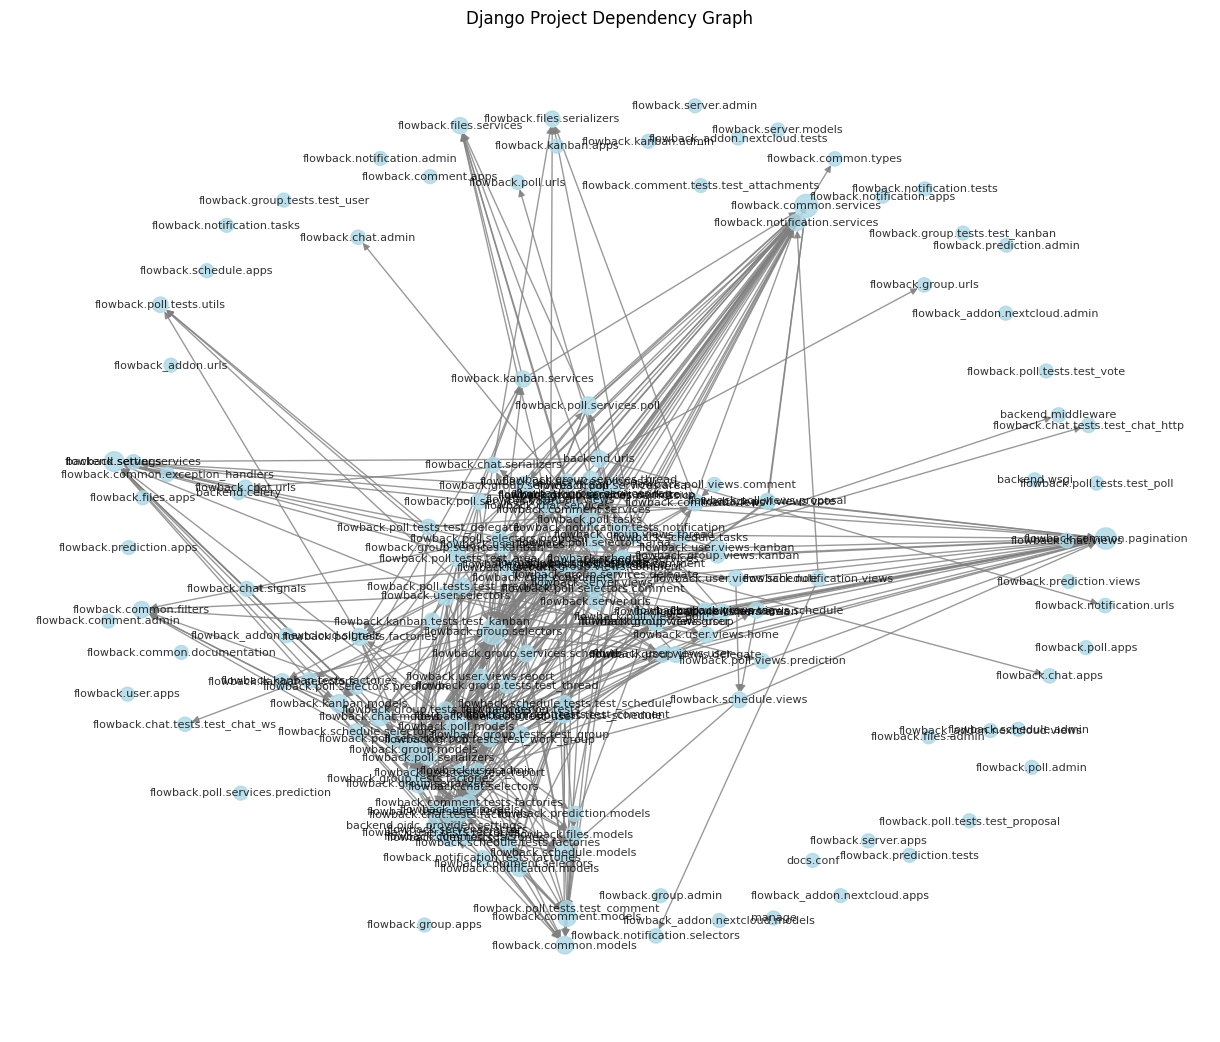


Top modules with highest outgoing dependencies:
backend.asgi: 14 dependencies
flowback.user.tests.test_user: 13 dependencies
flowback.poll.tests.test_area: 10 dependencies
flowback.group.selectors: 9 dependencies
flowback.user.selectors: 9 dependencies
backend.urls: 8 dependencies
flowback.chat.consumers: 8 dependencies
flowback.group.models: 8 dependencies
flowback.group.services.thread: 8 dependencies
flowback.poll.models: 8 dependencies

Top modules that are most depended upon:
flowback.group.models: 34 incoming dependencies
flowback.group.selectors: 31 incoming dependencies
flowback.user.models: 31 incoming dependencies
flowback.common.services: 29 incoming dependencies
flowback.common.pagination: 23 incoming dependencies
flowback.poll.models: 21 incoming dependencies
backend.settings: 18 incoming dependencies
flowback.common.tests: 16 incoming dependencies
flowback.comment.models: 12 incoming dependencies
flowback.group.tests.factories: 12 incoming dependencies


In [8]:
# Visualize the dependency graph
plt.figure(figsize=(12, 10))

# Use different layout algorithms based on graph size
if G.number_of_nodes() > 50:
    pos = nx.spring_layout(G)  # Force-directed layout for larger graphs
else:
    try:
        pos = nx.planar_layout(G)  # Planar layout for smaller graphs
    except:
        pos = nx.spring_layout(G)  # Fallback

# Size nodes based on their importance (centrality)
centrality = nx.degree_centrality(G)
node_size = [centrality[n] * 1000 + 100 for n in G.nodes()]

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        edge_color='gray', arrows=True, node_size=node_size,
        font_size=8, alpha=0.8)

plt.title("Django Project Dependency Graph")
plt.tight_layout()
plt.show()

# Show modules with highest dependencies (top 10)
if G.nodes:
    out_degrees = sorted([(n, d) for n, d in G.out_degree()], key=lambda x: x[1], reverse=True)
    print("\nTop modules with highest outgoing dependencies:")
    for module, degree in out_degrees[:10]:
        print(f"{module}: {degree} dependencies")

    in_degrees = sorted([(n, d) for n, d in G.in_degree()], key=lambda x: x[1], reverse=True)
    print("\nTop modules that are most depended upon:")
    for module, degree in in_degrees[:10]:
        print(f"{module}: {degree} incoming dependencies")